In [1]:
%cd ../..

/home/pristalovya/Документы/nlp-coursework


In [5]:
from datasets_ import DatasetLoader

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample

import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd

import sys

from nltk import WhitespaceTokenizer

from transformers import (
    pipeline,                       
    AutoModelForSequenceClassification,                       
    BertForSequenceClassification,                       
    AutoTokenizer,
    AdamW,
)

In [6]:
train, test = DatasetLoader.load_reviews_Review_Label_dataset(train_test_split=True,
                                                              classnames_to_int=True,
                                                              remove_neutral_class=True,
                                                              show_path=True,)
train.label[train['label'] == 2] = 1
test.label[test['label'] == 2] = 1

print(train.label.value_counts())
train = pd.concat([train, resample(train[train.label == 0], n_samples=41608, random_state=42)])
print(train.label.value_counts())

print(train.shape, test.shape)

/home/pristalovya/Документы/nlp-coursework/data/reviews_Review_Label/reviews_Review_Label.csv
1    48477
0     6869
Name: label, dtype: int64
0    48477
1    48477
Name: label, dtype: int64
(96954, 2) (23721, 2)


/tmp/ipykernel_14743/3168397547.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.label[train['label'] == 2] = 1
/tmp/ipykernel_14743/3168397547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.label[test['label'] == 2] = 1


In [89]:
%%time

checkpoint = "blanchefort/rubert-base-cased-sentiment-rusentiment"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)


CPU times: user 1.44 s, sys: 393 ms, total: 1.83 s
Wall time: 4.19 s


In [7]:
test

,review,label
25749,Большое количество фильмов советского кинемато...,1
44489,"Тяжело ответить на вопрос, что же такое Догвил...",1
53162,"В наше время такие героини, как скажем наприме...",0
25843,В 2001 году нам довелось познакомиться с новой...,1
44609,"«Это фильм?», «У них не хватило денег на декор...",1
...,...,...
14104,- Через столько лет?\r\n- Всегда\r\n\r\nБезусл...,1
22232,"После просмотра трейлера, я был под большим вп...",1
73314,"Многие не верят, но я легко подключаюсь к прои...",1
47848,"Как часто нам нужна поддержка? Да, пожалуй, оч...",1


In [9]:
# 

checkpoint = 'blanchefort/rubert-base-cased-sentiment-rusentiment'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [8]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_model_input_length=512):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_model_input_length = max_model_input_length
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        label = self.labels.iloc[idx]
        review_tokenized = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_model_input_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        input_ids = review_tokenized['input_ids'].flatten()
        attn_mask = review_tokenized['attention_mask'].flatten()
        
        return {
            'review': review,
            'input_ids': input_ids,
            'attention_mask': attn_mask,
            'label': label,
        }
        

In [11]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [11]:
model.bert.pooler.activation

Tanh()

In [10]:
class BertClassifier:
    def __init__(self, checkpoint, n_classes=2):
        
        self.model = BertForSequenceClassification.from_pretrained(checkpoint, ignore_mismatched_sizes=True)
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = 768
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)
        
        self.all_losses = []
        self.epoch_losses = []
        self.epoch_acc = []       
        

    def fit(self):
        self.model.train()
        losses = []
        correct_predictions = 0
        
        t = tqdm(train_dataloader, file=sys.stdout, ncols=100)

        for data in t:
            input_ids = data['input_ids'].to(self.device)
            attention_mask = data['attention_mask'].to(self.device).to(float)
            labels = data['label'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = outputs.logits.argmax(dim=1)
            
            loss = self.loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)

            losses.append(loss.item())

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            t.set_postfix(ordered_dict={'loss': loss.item()}, refresh=True)


        train_acc = correct_predictions.double() / len(train_dataset)
        train_loss = np.mean(losses)
        self.all_losses.extend(losses)
        self.epoch_losses.append(train_loss)
        self.epoch_acc.append(train_acc)
        return train_acc, train_loss
    
    
    def evaluate(self):
        self.model.eval()
        losses = []
        correct_predictions = 0
        
        all_preds = []
        
        t = tqdm(test_dataloader, file=sys.stdout, ncols=100)

        with torch.no_grad():
            for data in t:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                labels = data["label"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, labels)
                correct_predictions += torch.sum(preds == labels)
                
                all_preds.extend(preds.tolist())
                
                losses.append(loss.item())
                
                t.set_postfix(ordered_dict={'loss': loss.item()}, refresh=True)
                
        print('Classification report:')
        print(classification_report(test_dataset.labels, all_preds))

        val_acc = correct_predictions.double() / len(test_dataset)
        val_loss = np.mean(losses)
        return val_acc.item(), val_loss
    

    
    def train(self, n_epochs, pretrain_test=False):
        try:
            best_accuracy = 0

            if pretrain_test:
                print('Pre-training test:')
                val_acc, val_loss = self.evaluate()
                print(f'Test loss {val_loss} accuracy {val_acc}')
                print('-' * 10)

            for epoch in range(n_epochs):
                print(f'Epoch {epoch + 1}/{n_epochs}')
                train_acc, train_loss = self.fit()
                print(f'Train loss {train_loss} accuracy {train_acc}')

                val_acc, val_loss = self.evaluate()
                print(f'Test loss {val_loss} accuracy {val_acc}')
                print('-' * 10)
    
        except KeyboardInterrupt:
            print('Training was manually stopped. ')


In [11]:
clf = BertClassifier('blanchefort/rubert-base-cased-sentiment-rusentiment')

train_dataset = ReviewDataset(train.review, train.label, clf.tokenizer)
test_dataset = ReviewDataset(test.review, test.label, clf.tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
for param in clf.model.bert.parameters():
    param.requires_grad = False
print('All parameters:', sum(p.numel() for p in clf.model.parameters()))
print('Trainable parameters:', sum(p.numel() for p in clf.model.parameters() if p.requires_grad))

All parameters: 177854978
Trainable parameters: 1538


In [14]:
clf.train(3)

Pre-training test:
100%|█████████████████████████████████████████████████████████████| 742/742 [15:42<00:00,  1.27s/it]
Classification report:
              precision    recall  f1-score   support

           0       0.17      0.94      0.29      2979
           1       0.98      0.33      0.50     20742

    accuracy                           0.41     23721
   macro avg       0.57      0.64      0.39     23721
weighted avg       0.87      0.41      0.47     23721

Test loss 0.7539250175907927 accuracy 0.40951056026305804
----------
Epoch 1/3
100%|███████████████████████████████████████████████████████████| 1730/1730 [37:56<00:00,  1.32s/it]
Train loss 0.21480435333026282 accuracy 0.9120080945325769
100%|█████████████████████████████████████████████████████████████| 742/742 [15:36<00:00,  1.26s/it]
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66      2979
           1       0.95      0.96      0.96     20742

   

In [7]:
for param in clf.model.bert.parameters():
    param.requires_grad = True
print('All parameters:', sum(p.numel() for p in clf.model.parameters()))
print('Trainable parameters:', sum(p.numel() for p in clf.model.parameters() if p.requires_grad))

All parameters: 177854978
Trainable parameters: 177854978


In [8]:
clf.optimizer = torch.optim.Adam(clf.model.parameters(), lr=1e-6)
print(clf.optimizer)
clf.train(3)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)
Epoch 1/3
  0%|                                                                      | 0/3460 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 5.78 GiB total capacity; 4.45 GiB already allocated; 52.38 MiB free; 4.49 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<IPython.core.display.Javascript object>


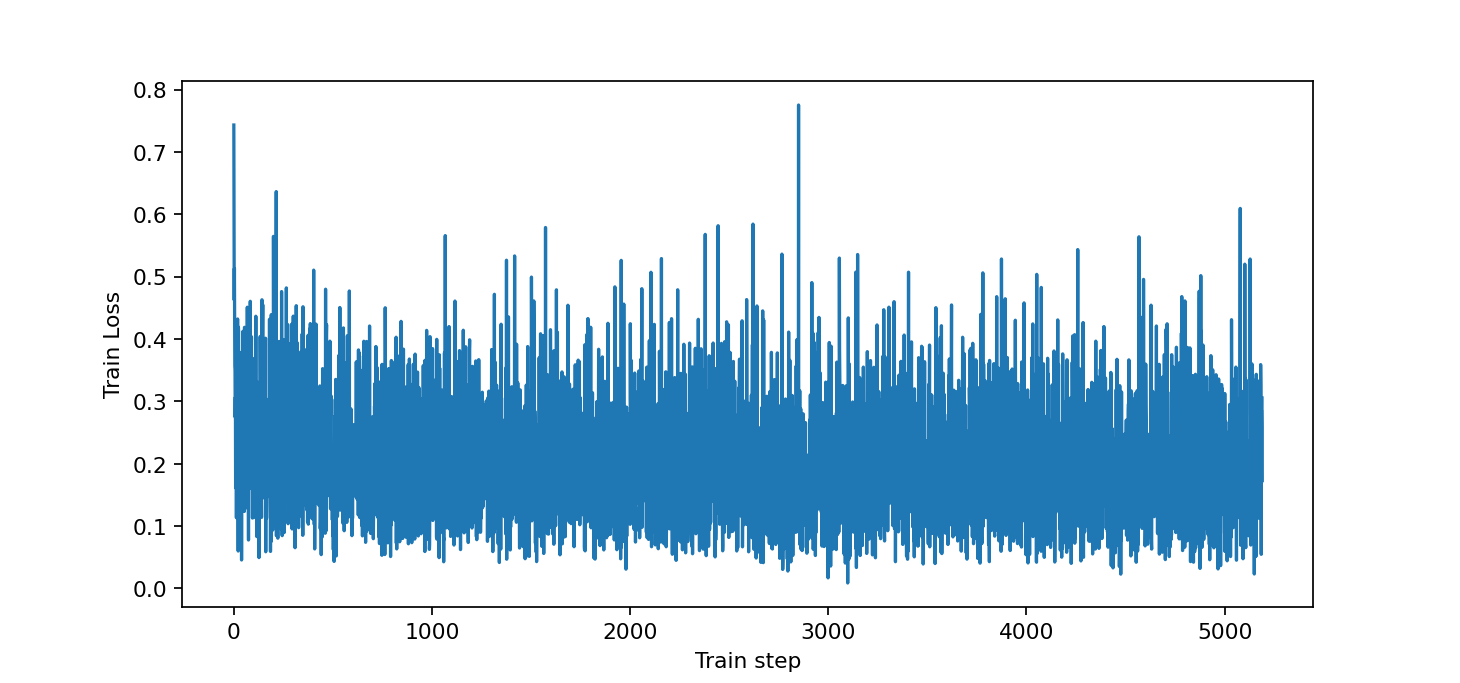

In [17]:
plt.plot(clf.all_losses)
plt.xlabel('Train step')
plt.ylabel('Train Loss')

plt.show()

<IPython.core.display.Javascript object>


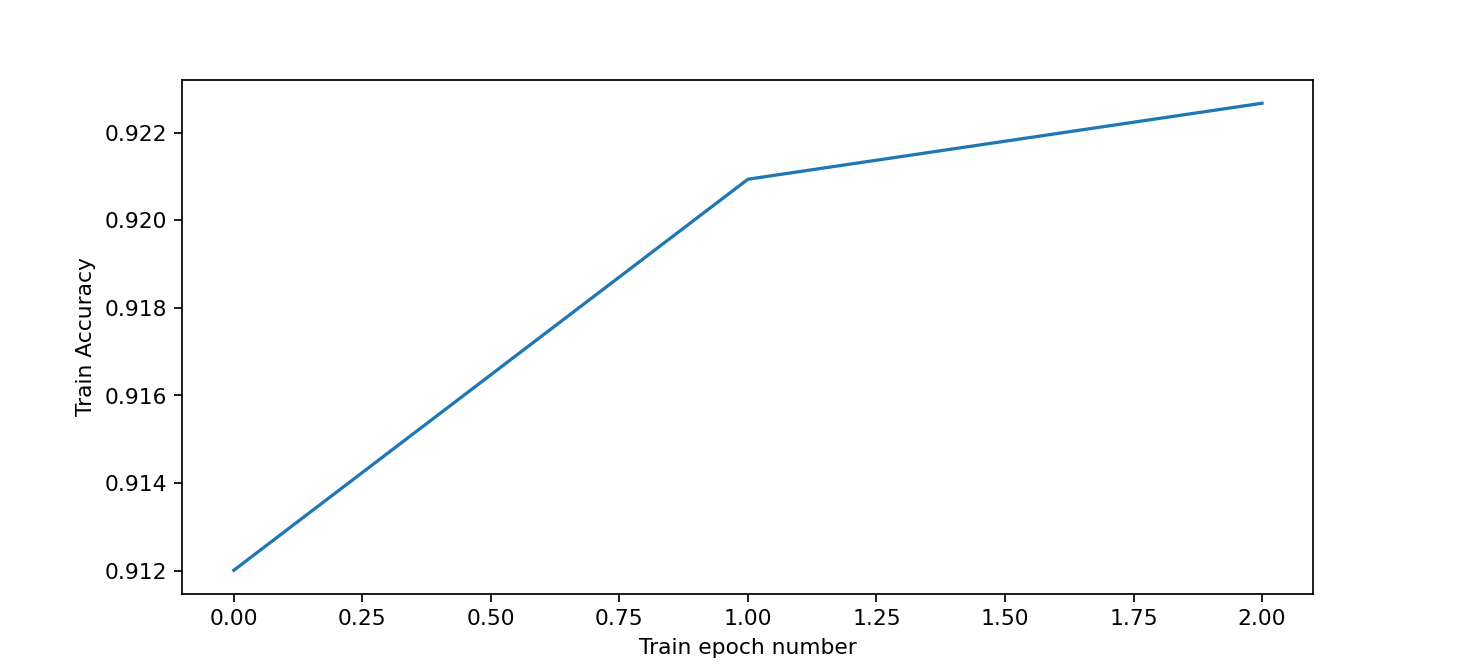

In [19]:
clf.epoch_acc = list(map(lambda t: t.cpu(), clf.epoch_acc))

plt.plot(clf.epoch_acc)
plt.xlabel('Train epoch number')
plt.ylabel('Train Accuracy')

plt.show()

<IPython.core.display.Javascript object>


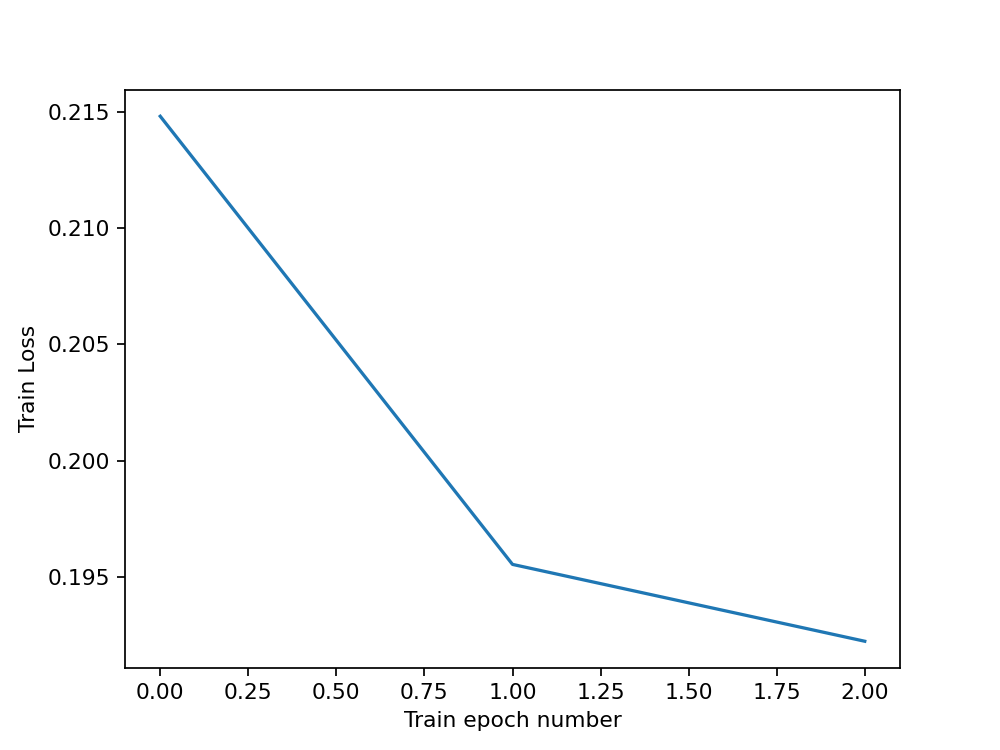

In [20]:
plt.plot(clf.epoch_losses)
plt.xlabel('Train epoch number')
plt.ylabel('Train Loss')

plt.show()